<a href="https://colab.research.google.com/github/jd-gebbia/Applied_Analytics/blob/main/AAPM_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()

Saving noc_regions.csv to noc_regions.csv
Saving OlympicHistoryAthletes.csv to OlympicHistoryAthletes.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_style("whitegrid")

In [4]:
olympic = pd.read_csv("OlympicHistoryAthletes.csv")
noc = pd.read_csv("noc_regions.csv")
olympic = pd.merge(olympic, noc, how='left', on='NOC')
olympic.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN


In [5]:
olympic.shape

(271116, 17)

## Processing null values

In [6]:
olympic.isnull().sum().sort_values(ascending=False)[:7]

notes     266077
Medal     231333
Weight     62875
Height     60171
Age         9474
region       370
Team           0
dtype: int64

There are so many null values, so it is necessary to precess some of them.  

In [7]:
olympic[olympic.region.isnull()][['NOC','Team','notes']].drop_duplicates()

,NOC,Team,notes
578,SGP,Singapore,NaN
6267,ROT,Refugee Olympic Athletes,Refugee Olympic Team
44376,SGP,June Climene,NaN
61080,UNK,Unknown,Unknown
64674,TUV,Tuvalu,Tuvalu
80986,SGP,Rika II,NaN
108582,SGP,Singapore-2,NaN
235895,SGP,Singapore-1,NaN


In [8]:
olympic.loc[olympic.NOC=='SGP','region'] = 'Singapore'
olympic.loc[olympic.NOC=='UNK','region'] = 'Unknown'
olympic.loc[olympic.NOC=='ROT','region'] = 'Refugee Olympic Team'
olympic.loc[olympic.NOC=='TUV','region'] = 'Tuvalu'

In [9]:
olympic.Medal.isnull().mean() # only about 15% athletes win medals

0.853262072323286

Don't process null values of medals so that it is easy to distinguish athletes won and didn't win.         
Null values of regions and notes are unnecessary to process in this stage.

In [10]:
# Null values of weight, height, age should be imputed by the average of the particular sport
olympic['Weight'] = olympic.groupby(['Sport'])['Weight'].apply(lambda x: x.fillna(x.mean()))
olympic['Height'] = olympic.groupby(['Sport'])['Height'].apply(lambda x: x.fillna(x.mean()))
olympic['Age'] = olympic.groupby(['Sport'])['Age'].apply(lambda x: x.fillna(x.mean()))

In [11]:
olympic.isnull().sum().sort_values(ascending=False)[:5]

notes     266077
Medal     231333
Weight       217
Height        99
NOC            0
dtype: int64

There are still some null values in height and weight, maybe every record in some sports or some games is missing.         
Using average to impute them is a good approach.

In [12]:
avgw = olympic.Weight.mean()
avgh = olympic.Height.mean()
olympic.loc[olympic.Weight.isnull(),"Weight"] = avgw
olympic.loc[olympic.Height.isnull(),"Height"] = avgh

In [13]:
olympic.isnull().sum().sort_values(ascending=False)[:5]

notes    266077
Medal    231333
NOC           0
Name          0
Sex           0
dtype: int64

## Basic statistic info

Statistic for numeric variables.

In [14]:
olympic[['Age','Height', 'Weight']].describe().round(1)

,Age,Height,Weight
count,271116.0,271116.0,271116.0
mean,25.6,175.1,70.6
std,6.4,9.7,13.1
min,10.0,127.0,25.0
25%,22.0,169.0,62.0
50%,25.0,175.0,70.0
75%,28.0,181.0,77.0
max,97.0,226.0,214.0


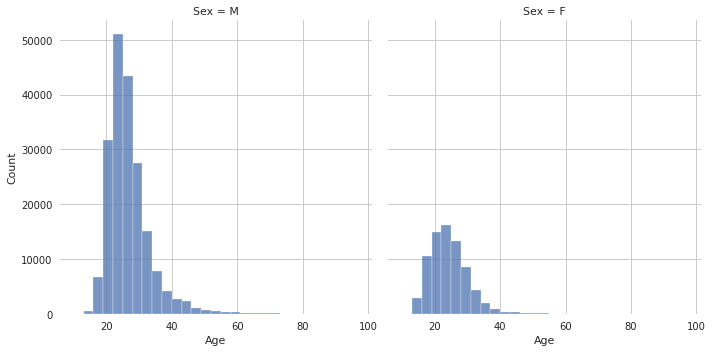

In [15]:
sns.displot(olympic, x="Age", col="Sex", binwidth=3, height=5, facet_kws=dict(margin_titles=True))

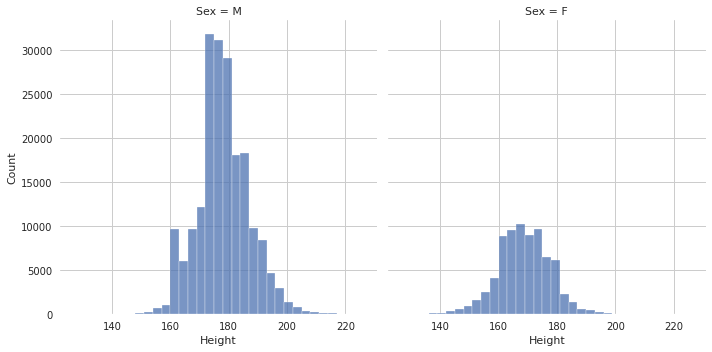

In [16]:
sns.displot(olympic, x="Height", col="Sex", binwidth=3, height=5, facet_kws=dict(margin_titles=True))

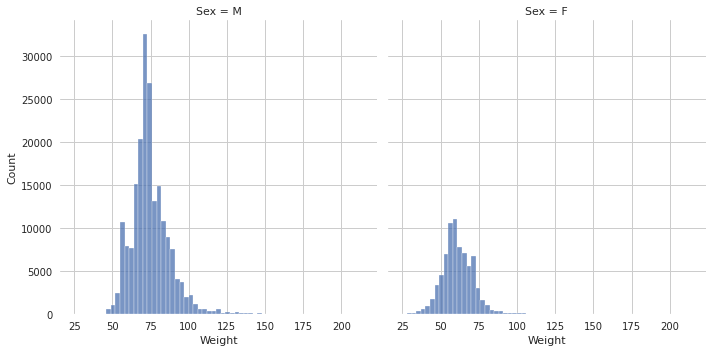

In [17]:
sns.displot(olympic, x="Weight", col="Sex", binwidth=3, height=5, facet_kws=dict(margin_titles=True))

The distribution of age and weight is skewed. Except for count, there isn't obvious difference between male and female athletes.

## Visualization

### For the US
First, select the United States as the research object.

In [18]:
olympic['region'].drop_duplicates()

0              China
2            Denmark
4        Netherlands
10               USA
28           Finland
            ...     
61080        Unknown
64674         Tuvalu
80081         Kosovo
91746    South Sudan
96572        Lesotho
Name: region, Length: 209, dtype: object

#### Number and ratio of medals

In [19]:
# Number of medals of the US
medals_year = olympic[olympic.region=='USA'].groupby(['Year', 'Season', 'Medal'])['Medal'].count().to_frame(name = 'Count').reset_index()

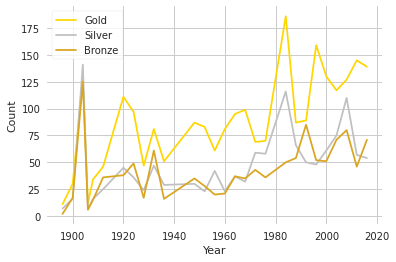

In [20]:
# Summer
summer = medals_year[medals_year.Season=='Summer']
sns.lineplot(x='Year', y='Count', data=summer[summer.Medal=='Gold'], color='gold', label='Gold')
sns.lineplot(x='Year', y='Count', data=summer[summer.Medal=='Silver'], color='silver', label='Silver')
sns.lineplot(x='Year', y='Count', data=summer[summer.Medal=='Bronze'], color='goldenrod', label='Bronze')
plt.legend(loc="upper left", frameon=True)

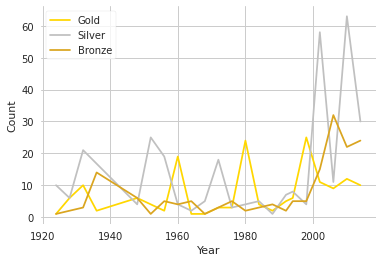

In [21]:
# Winter
winter = medals_year[medals_year.Season=='Winter']
sns.lineplot(x='Year', y='Count', data=winter[winter.Medal=='Gold'], color='gold', label='Gold')
sns.lineplot(x='Year', y='Count', data=winter[winter.Medal=='Silver'], color='silver', label='Silver')
sns.lineplot(x='Year', y='Count', data=winter[winter.Medal=='Bronze'], color='goldenrod', label='Bronze')
plt.legend(loc="upper left", frameon=True)

The ratio can show more info. Although the number of medals is on the rise, the actual percentage changes are not obvious.

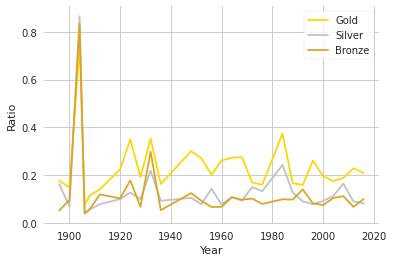

In [22]:
total_medals = olympic.groupby(['Year', 'Season', 'Medal'])['Medal'].count().to_frame(name = 'Total').reset_index()
medals_year = pd.merge(medals_year, total_medals)
medals_year['Ratio'] = medals_year['Count'] / medals_year['Total']

summer = medals_year[medals_year.Season=='Summer']
sns.lineplot(x='Year', y='Ratio', data=summer[summer.Medal=='Gold'], color='gold', label='Gold')
sns.lineplot(x='Year', y='Ratio', data=summer[summer.Medal=='Silver'], color='silver', label='Silver')
sns.lineplot(x='Year', y='Ratio', data=summer[summer.Medal=='Bronze'], color='goldenrod', label='Bronze')
plt.legend(loc="upper right", frameon=True)

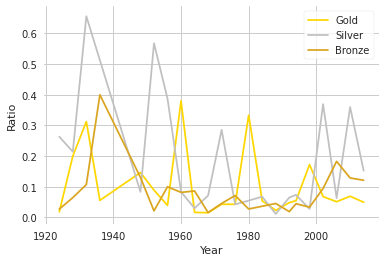

In [23]:
winter = medals_year[medals_year.Season=='Winter']
sns.lineplot(x='Year', y='Ratio', data=winter[winter.Medal=='Gold'], color='gold', label='Gold')
sns.lineplot(x='Year', y='Ratio', data=winter[winter.Medal=='Silver'], color='silver', label='Silver')
sns.lineplot(x='Year', y='Ratio', data=winter[winter.Medal=='Bronze'], color='goldenrod', label='Bronze')
plt.legend(loc="upper right", frameon=True)

There is an advantage in the Summer Olympics. The ratio of gold medals won in the Winter Olympic is relatively small.

#### Sports with the most medals

In [24]:
medals_sport = olympic[(olympic.Season=='Summer')&(olympic.Medal=='Gold')]
medals_sport = medals_sport.groupby(['region', 'Year', 'Sport'])['Sport'].count().to_frame(name = 'Count').reset_index()

In [25]:
print(min(medals_sport.Year))
print(max(medals_sport.Year))

1896
2016


Let's look at the performance of the US in 1896 and 2016. Focus on Summer Olympic and gold medal.

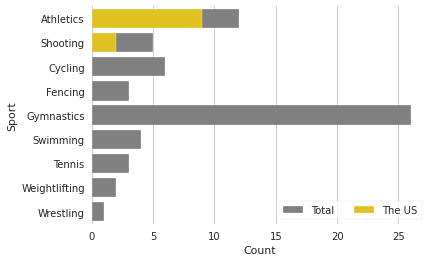

In [26]:
medals_1896 = medals_sport[medals_sport.Year==1896]
total_1896 = medals_1896.groupby(['Sport'])['Count'].sum().to_frame(name = 'Total').reset_index()
us_1896 = medals_1896[medals_1896.region=='USA']
us_1896 = us_1896.merge(total_1896, how='right', on='Sport').sort_values("Count", ascending=False)

sns.barplot(x="Total", y="Sport", data=us_1896, label="Total", color="gray", ci=False)
sns.barplot(x="Count", y="Sport", data=us_1896, label="The US", color="gold")
plt.legend(ncol=2, loc="lower right", frameon=True)

The US only got gold medals in two sport in 1896. One reason is that there were only 9 sport at that time.      
Let's look at the data of 2016.

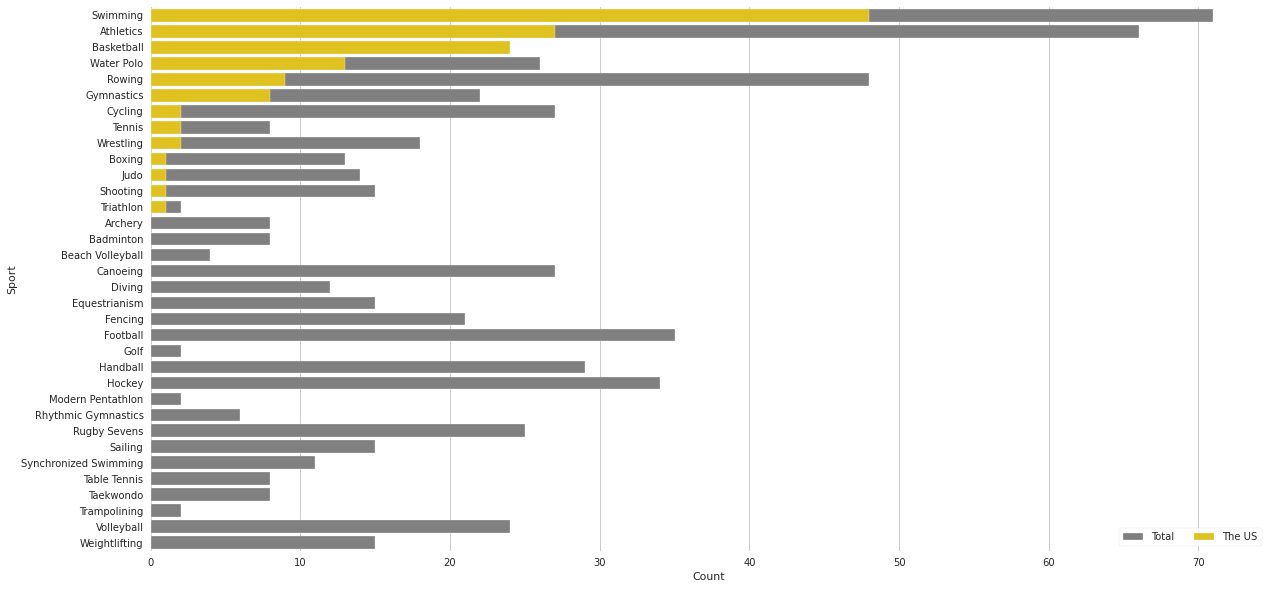

In [27]:
medals_2016 = medals_sport[medals_sport.Year==2016]
total_2016 = medals_2016.groupby(['Sport'])['Count'].sum().to_frame(name = "Total").reset_index()
us_2016 = medals_2016[medals_2016.region=='USA']
us_2016 = us_2016.merge(total_2016, how='right', on='Sport').sort_values("Count", ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x="Total", y="Sport", data=us_2016, label="Total", color="gray", ci=False)
sns.barplot(x="Count", y="Sport", data=us_2016, label="The US", color="gold")
plt.legend(ncol=2, loc="lower right", frameon=True)

In [28]:
us_2016['Ratio'] = us_2016.Count / us_2016.Total
us_2016[['Sport', 'Total', 'Ratio']][us_2016.Ratio>0].sort_values('Ratio', ascending=False)

,Sport,Total,Ratio
3,Basketball,24,1.000000
23,Swimming,71,0.676056
31,Water Polo,26,0.500000
29,Triathlon,2,0.500000
1,Athletics,66,0.409091
13,Gymnastics,22,0.363636
27,Tennis,8,0.250000
19,Rowing,48,0.187500
33,Wrestling,18,0.111111
5,Boxing,13,0.076923


The US won all gold medals in Basketball in the 2016 Summer Olympics. And very high ratio of gold medals in Swimming, Water Polo and Triathlon.        
Let's also look at the ratio of gold medals since the first Summer Olympic.

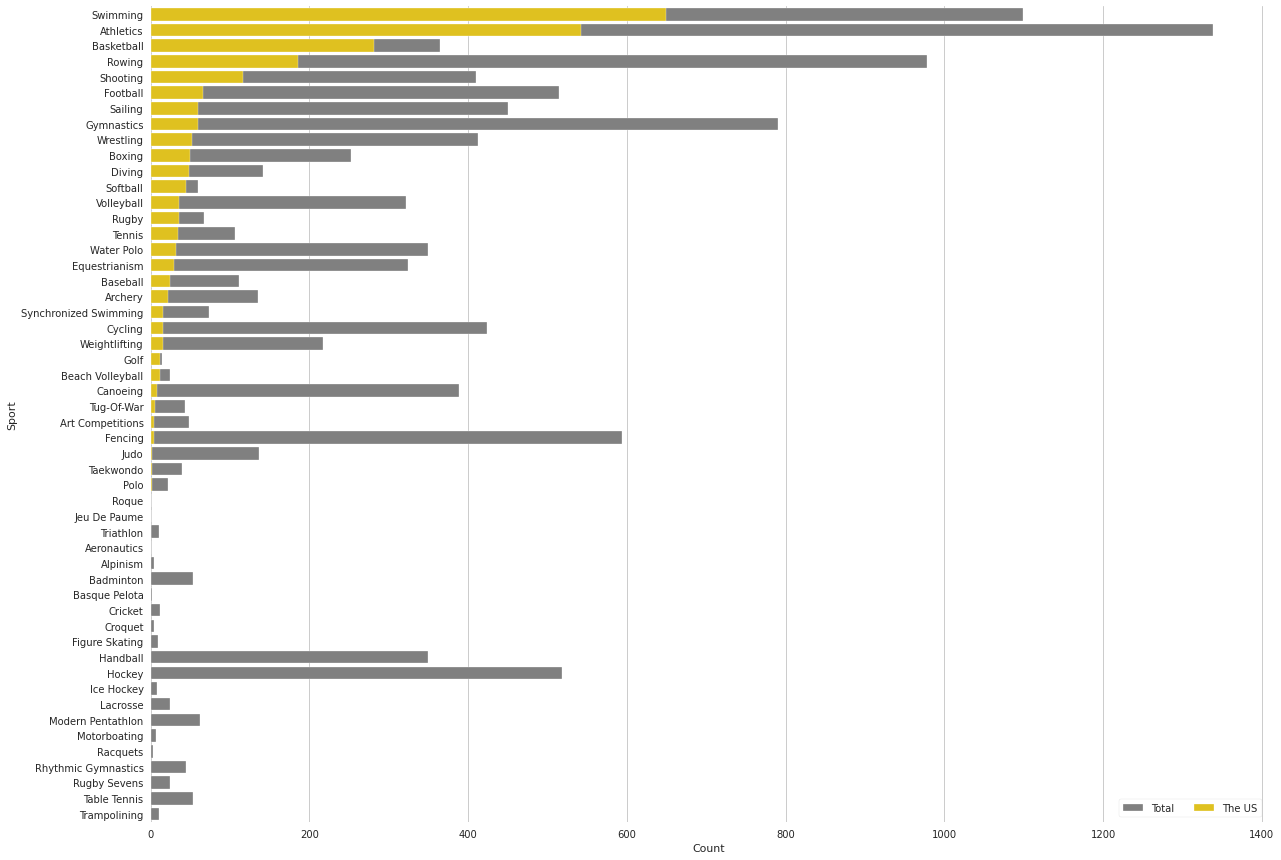

In [29]:
total_allyr = medals_sport.groupby(['Sport'])['Count'].sum().to_frame(name = 'Total').reset_index()
us_allyr = medals_sport[medals_sport.region=='USA'].groupby(['Sport'])['Count'].sum().to_frame(name = 'Count').reset_index()
us_allyr = us_allyr.merge(total_allyr, how='right', on='Sport').sort_values("Count", ascending=False)

plt.figure(figsize=(20, 15))
sns.barplot(x="Total", y="Sport", data=us_allyr, label="Total", color="gray", ci=False)
sns.barplot(x="Count", y="Sport", data=us_allyr, label="The US", color="gold")
plt.legend(ncol=2, loc="lower right", frameon=True)

Next, let's look at top 10 sport with the highest percentage of gold medals.

In [30]:
us_allyr['Ratio'] = us_allyr.Count / us_allyr.Total
us_allyr[['Sport', 'Total', 'Ratio']].sort_values('Ratio', ascending=False)[:10]

,Sport,Total,Ratio
25,Jeu De Paume,1,1.000000
33,Roque,1,1.000000
20,Golf,15,0.800000
7,Basketball,365,0.769863
39,Softball,60,0.750000
40,Swimming,1099,0.590537
35,Rugby,67,0.537313
9,Beach Volleyball,24,0.500000
4,Athletics,1339,0.404780
15,Diving,142,0.338028


The US have obvious advantages in Basketball, Softball, Swimming and Rugby.   
Jeu De Paume and Roque were only held one time. Let's look at them closer.

In [31]:
olympic[(olympic.Sport=='Jeu De Paume')|(olympic.Sport=='Roque')].sort_values('Sport')[['Games','region','Sport','Event']].drop_duplicates()

,Games,region,Sport,Event
21488,1908 Summer,UK,Jeu De Paume,Jeu De Paume Men's Singles
82805,1908 Summer,USA,Jeu De Paume,Jeu De Paume Men's Singles
29994,1904 Summer,USA,Roque,Roque Men's Singles


Jeu De Paume was held in 1908 and Roque in 1904, only USA and UK participated them.

##### Basketball

The percentage of gold medals obtained in basketball in 2016 is greater than the overall performance.       
Let's look at the change in the proportion of basketball gold medals over time.

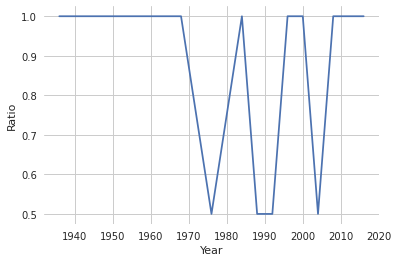

In [32]:
bskt = medals_sport[medals_sport.Sport=='Basketball']
bskt_yr = bskt.groupby(['Year'])['Count'].sum().to_frame(name = 'Total').reset_index()
us_bskt = bskt[bskt.region=='USA'].groupby(['Year'])['Count'].sum().to_frame(name = 'Count').reset_index()
us_bskt = us_bskt.merge(bskt_yr, how='left', on='Year')
us_bskt['Ratio'] = us_bskt['Count'] / us_bskt['Total']

sns.lineplot(x='Year', y='Ratio', data=us_bskt)

The US only lost 4 games. Let's see the winners.

In [33]:
bskt_teams = bskt[(bskt.Year.isin(us_bskt[us_bskt.Ratio<1].Year))&(bskt.region!='USA')][['region','Year']].sort_values('Year')
df = olympic[(olympic.Sport=='Basketball')&(olympic.Medal=='Gold')&(olympic.Season=='Summer')][['region','Team','Year','Event']].drop_duplicates()
pd.merge(df, bskt_teams, how='right')

,region,Team,Year,Event
0,Russia,Soviet Union,1976,Basketball Women's Basketball
1,Russia,Soviet Union,1988,Basketball Men's Basketball
2,Russia,Unified Team,1992,Basketball Women's Basketball
3,Argentina,Argentina,2004,Basketball Men's Basketball


Russia and Argentina have beaten the US team, in men's/women's basketball.

##### Swimming

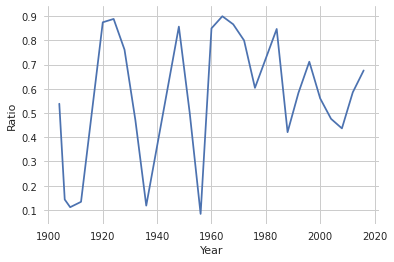

In [34]:
swm = medals_sport[medals_sport.Sport=='Swimming']
swm_yr = swm.groupby(['Year'])['Count'].sum().to_frame(name = 'Total').reset_index()
us_swm = swm[swm.region=='USA'].groupby(['Year'])['Count'].sum().to_frame(name = 'Count').reset_index()
us_swm = us_swm.merge(swm_yr, how='left', on='Year')
us_swm['Ratio'] = us_swm['Count'] / us_swm['Total']

sns.lineplot(x='Year', y='Ratio', data=us_swm)

The performance of Swimming is unstable. It has maintained a relatively high level after 1990.

### Compare with other countries

Let's look at top countries with the most gold medals in Summer Olympic.

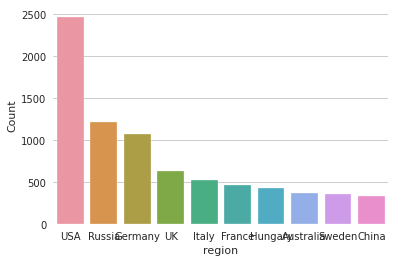

In [35]:
top_all = olympic[(olympic.Medal=='Gold')&(olympic.Season=='Summer')].groupby('region')['Medal'].count().sort_values(ascending=False).to_frame(name = 'Count').reset_index()[:10]
sns.barplot(x='region', y='Count', data=top_all)

Top 5 are USA, Russia, Germany, UK and Italy.

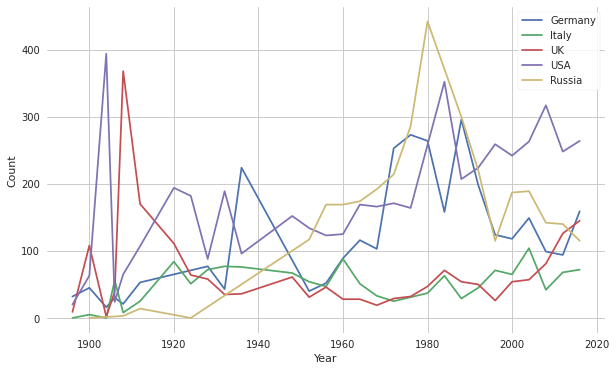

In [36]:
top_c = olympic[(olympic.Medal=='Gold')&(olympic.Season=='Summer')].groupby('region')['Medal'].count().sort_values(ascending=False)[:5].index
medals_c = olympic.loc[olympic['region'].isin(top_c),].groupby(['Year', 'Season', 'region'])['Medal'].count().to_frame(name = 'Count').reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Count', hue='region', ci=False, data=medals_c[medals_c.Season=='Summer'])
plt.legend(frameon=True)

The number of medals in Russia has fallen precipitously since 1980, which may be related to the collapse of the Soviet Union.      
Italy has not made progress.

How about 2016？

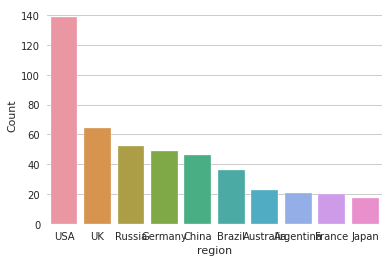

In [37]:
top_2016 = olympic[(olympic.Medal=='Gold')&(olympic.Season=='Summer')&(olympic.Year==2016)].groupby('region')['Medal'].count().sort_values(ascending=False).to_frame(name = 'Count').reset_index()[:10]
sns.barplot(x='region', y='Count', data=top_2016)

In 2016, China is the 5th country. In addition, Brazil, Argentina and Japan also entered the top 10.       
Compared to the general ranking, Italy, Hungary, and Sweden have disappeared.

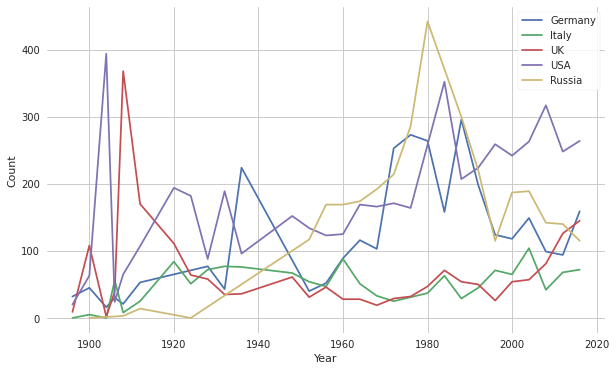

In [38]:
medals_c = olympic.loc[olympic['region'].isin(top_c),].groupby(['Year', 'Season', 'region'])['Medal'].count().to_frame(name = 'Count').reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Count', hue='region', ci=False, data=medals_c[medals_c.Season=='Summer'])
plt.legend(frameon=True)

China has made rapid progress in recent decades.

## For female athletes

### Who was the first femal athlete in the histroy of Olympic?



In [39]:
min(olympic[olympic.Sex=='F'].Year)

1900

Women began to participate in Summer Olympic from 1900.

In [40]:
fm_1900 = olympic[(olympic.Sex=='F')&(olympic.Year==1900)][['Sport','Event','region','Name','Age','Medal']].sort_values(['Sport','Event','Medal'])
fm_1900

,Sport,Event,region,Name,Age,Medal
54280,Croquet,"Croquet Mixed Singles, One Ball",France,Mme. Desprs,33.733333,NaN
69403,Croquet,"Croquet Mixed Singles, One Ball",France,Jeanne Marie Henriette Filleaul-Brohy (Hantjens-),33.000000,NaN
175578,Croquet,"Croquet Mixed Singles, One Ball",France,Marie Pierrette Sophie Pauline Ohier,46.000000,NaN
54281,Croquet,"Croquet Mixed Singles, Two Balls",France,Mme. Desprs,33.733333,NaN
69404,Croquet,"Croquet Mixed Singles, Two Balls",France,Jeanne Marie Henriette Filleaul-Brohy (Hantjens-),33.000000,NaN
175579,Croquet,"Croquet Mixed Singles, Two Balls",France,Marie Pierrette Sophie Pauline Ohier,46.000000,NaN
85934,Equestrianism,Equestrianism Mixed Hacks And Hunter Combined,Italy,Elvira Guerra,34.390831,NaN
164478,Equestrianism,Equestrianism Mixed Hacks And Hunter Combined,France,Moulin,34.390831,NaN
192747,Golf,Golf Women's Individual,USA,"Myra Abigail ""Abbie"" Pratt (Pankhurst-, Wright...",41.000000,Bronze
283,Golf,Golf Women's Individual,USA,Margaret Ives Abbott (-Dunne),23.000000,Gold


In [41]:
fm_1900[fm_1900.Medal=='Gold']

,Sport,Event,region,Name,Age,Medal
283,Golf,Golf Women's Individual,USA,Margaret Ives Abbott (-Dunne),23.0,Gold
51668,Sailing,Sailing Mixed 1-2 Ton,Switzerland,Hlne de Pourtals (Barbey-),32.0,Gold
44449,Tennis,Tennis Mixed Doubles,UK,Charlotte Reinagle Cooper (-Sterry),29.0,Gold
44448,Tennis,Tennis Women's Singles,UK,Charlotte Reinagle Cooper (-Sterry),29.0,Gold


Croquet and Equestrianism have no medal records.      
There were also Golf, Sailing and Tennis, and athletes from different countries got medals.      
Charlotte Reinagle Cooper from UK even got two gold medals.

### Changes in the participation of female athletes over time

Focus on Summer Olympic.

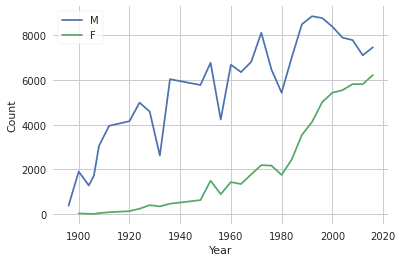

In [42]:
# Ratio of female athletes over time
fm_year = olympic[olympic.Season=='Summer'].groupby(['Year', 'Sex'])['Sex'].count().to_frame(name = 'Count').reset_index()
total_mf = olympic[olympic.Season=='Summer'].groupby(['Year'])['Sex'].count().to_frame(name = 'Total').reset_index()
fm_year = pd.merge(fm_year, total_mf)
fm_year['Ratio'] = fm_year['Count'] / fm_year['Total']

sns.lineplot(x='Year', y='Count', hue='Sex', data=fm_year)
plt.legend(frameon=True)

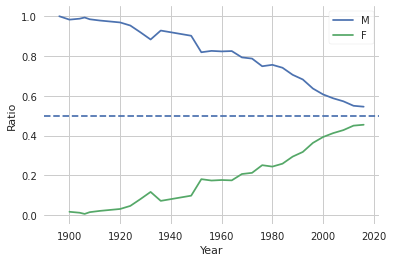

In [43]:
sns.lineplot(x='Year', y='Ratio', hue='Sex', data=fm_year)
plt.axhline(0.5, ls='--')
plt.legend(frameon=True)

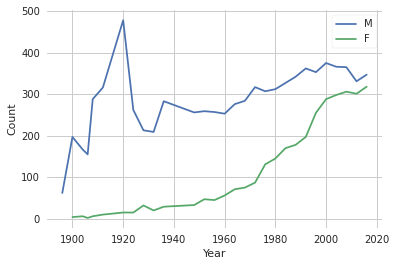

In [44]:
# Performance of female athletes over time - gold medals count
fm_medals = olympic[olympic.Season=='Summer'].groupby(['Year', 'Medal', 'Sex'])['Medal'].count().to_frame(name = 'Count').reset_index()
total_medals = olympic[olympic.Season=='Summer'].groupby(['Year','Medal'])['Sex'].count().to_frame(name = 'Total').reset_index()
fm_medals = pd.merge(fm_medals, total_medals)
fm_medals['Ratio'] = fm_medals['Count'] / fm_medals['Total']

sns.lineplot(x='Year', y='Count', hue='Sex', data=fm_medals[fm_medals.Medal=='Gold'])
plt.legend(frameon=True)

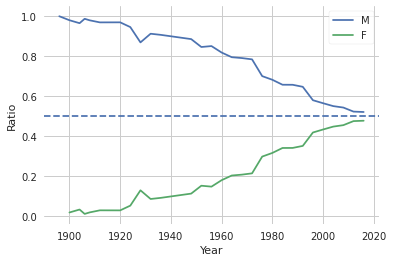

In [45]:
sns.lineplot(x='Year', y='Ratio', hue='Sex', data=fm_medals[fm_medals.Medal=='Gold'])
plt.axhline(0.5, ls='--')
plt.legend(frameon=True)

The ratio of male and female athletes is constantly approaching 1:1.     
The proportion of female athletes shows the same trend as the proportion of gold medals they receive.

### Age and performance

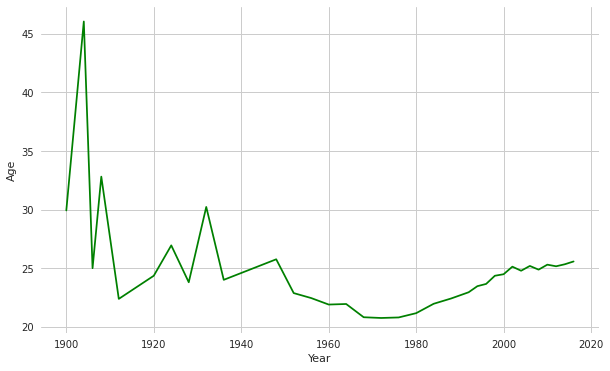

In [46]:
# Change of average age over time
age_year = olympic[olympic.Sex=='F'].groupby(['Year'])['Age'].mean().to_frame(name = 'Age').reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Age', data=age_year, color='green')

In [47]:
age_year[age_year['Age']>30]

,Year,Age
1,1904,46.050355
3,1908,32.811327
8,1932,30.224823


The average age of female athletes is very high in 1904 and 1908.

In [48]:
high_age = olympic[(olympic.Sex=='F')&((olympic.Year==1904)|(olympic.Year==1908))]
high_age.shape

(63, 17)

In [49]:
high_age.groupby(['Year','Sport','Event','region'])['Age'].mean().round(1).to_frame(name = 'Average Age')

Average Age
Year Sport          Event                                      region              
1904 Archery        Archery Women's Double Columbia Round      USA             45.3
                    Archery Women's Double National Round      USA             45.3
                    Archery Women's Team Round                 USA             48.2
1908 Archery        Archery Women's Double National Round      UK              37.0
     Figure Skating Figure Skating Mixed Pairs                 Germany         23.0
                                                               UK              23.5
                    Figure Skating Women's Singles             Germany         22.0
                                                               Sweden          22.0
                                                               UK              24.4
     Motorboating   Motorboating Mixed B-Class (Under 60 Feet) UK              26.0
     Sailing        Sailing Mixed 7 metres                     UK              30.3
     Tennis         Tennis Women's Singles                     UK              31.2
                    Tennis Women's Singles, Covered Courts     Sweden          35.0
                                                               UK              29.4

In [50]:
olympic[(olympic.Sex=='F')&(olympic.Year==1904)][['Event','Name','Age','Medal']].sort_values('Age', ascending=False)

,Event,Name,Age,Medal
190950,Archery Women's Double Columbia Round,"Lida Peyton ""Eliza"" Pollock (McMillen-)",63.000000,Bronze
190951,Archery Women's Double National Round,"Lida Peyton ""Eliza"" Pollock (McMillen-)",63.000000,Bronze
190952,Archery Women's Team Round,"Lida Peyton ""Eliza"" Pollock (McMillen-)",63.000000,Gold
262863,Archery Women's Double Columbia Round,Emily Woodruff (Smiley-),58.000000,NaN
262864,Archery Women's Double National Round,Emily Woodruff (Smiley-),58.000000,NaN
262865,Archery Women's Team Round,Emily Woodruff (Smiley-),58.000000,Gold
44365,Archery Women's Double Columbia Round,Emma C. Cooke,55.000000,Silver
44366,Archery Women's Double National Round,Emma C. Cooke,55.000000,Silver
99506,Archery Women's Double Columbia Round,"Matilda ""Lida"" Howell (Scott-)",44.000000,Gold
99507,Archery Women's Double National Round,"Matilda ""Lida"" Howell (Scott-)",44.000000,Gold


In 1904, only female athletes from the United States participated, and only Archery was established for them.       
The oldest athlete was even 63 years old.

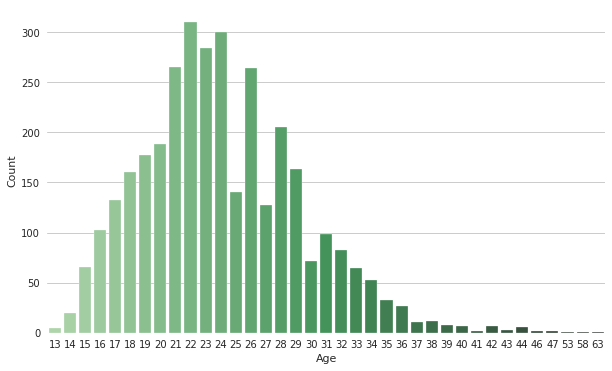

In [51]:
age_medal = olympic[(olympic.Sex=='F')&(olympic.Medal=='Gold')].groupby('Age')['Medal'].count().to_frame(name = 'Count').reset_index()
age_medal['Age'] = age_medal['Age'].astype(int)
plt.figure(figsize=(10, 6))
sns.barplot(x='Age', y='Count', data=age_medal, ci=False, palette="Greens_d")

Some athletes with age greater than 50 and even 60 got a gold medal! Let's see who they are and which sport they do.

In [52]:
olympic[(olympic.Sex=='F')&(olympic.Medal=='Gold')&(olympic.Age>50)]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
170250,85547,Sybil Fenton Newall,F,53.0,173.203085,70.011135,Great Britain,GBR,1908 Summer,1908,Summer,London,Archery,Archery Women's Double National Round,Gold,UK,NaN
190952,95906,"Lida Peyton ""Eliza"" Pollock (McMillen-)",F,63.0,173.203085,70.011135,Cincinnati Archers,USA,1904 Summer,1904,Summer,St. Louis,Archery,Archery Women's Team Round,Gold,USA,NaN
262865,131533,Emily Woodruff (Smiley-),F,58.0,173.203085,70.011135,Cincinnati Archers,USA,1904 Summer,1904,Summer,St. Louis,Archery,Archery Women's Team Round,Gold,USA,NaN


Sybil Fenton Newall won the Archery Women's Double National Round gold medal in 1908.        
Another two athletes won the Archery Women's Team Round gold medal in 1904.

### Performance of female athletes from different countries

In [53]:
def fm_medals_yr(year):

  fm_noc = olympic[(olympic.Sex=='F')&(olympic.Season=='Summer')].groupby(['Year','region','Medal'])['Medal'].count().to_frame(name = 'Count').reset_index()
  fm_noc = fm_noc[fm_noc.Year==year]
  fm_noc_ttl = fm_noc.groupby('region')['Count'].sum().to_frame(name = 'Total').reset_index()
  fm_noc_gold = fm_noc[fm_noc.Medal=='Gold'][['region','Count']]
  fm_noc_silver = fm_noc[fm_noc.Medal=='Silver'][['region','Count']]
  fm_noc_bronze = fm_noc[fm_noc.Medal=='Bronze'][['region','Count']]
  fm_noc = fm_noc_ttl.merge(fm_noc_gold,on='region').rename(columns={'Count':'Gold'})
  fm_noc = fm_noc.merge(fm_noc_silver,on='region').rename(columns={'Count':'Silver'})
  fm_noc = fm_noc.merge(fm_noc_bronze,on='region').rename(columns={'Count':'Bronze'}).sort_values('Total', ascending=False)
  
  return fm_noc

def visual_medals(fm_noc):

  df = fm_noc.copy()
  df['gs'] = df['Gold']+df['Silver']
  plt.figure(figsize=(10, 8))
  sns.barplot(x="Total", y="region", data=df, label="Bronze", color="goldenrod")
  sns.barplot(x="gs", y="region", data=df, label="Silver", color="silver")
  sns.barplot(x="Gold", y="region", data=df, label="Gold", color="gold")
  plt.legend(loc="lower right", frameon=True)

  return plt

These two functions can be used to analyze the awards of female athletes from different countries in different years.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

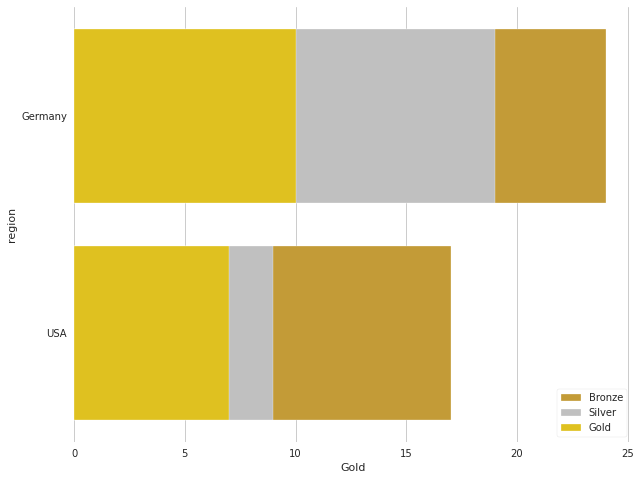

In [78]:
visual_medals(fm_medals_yr(1936))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

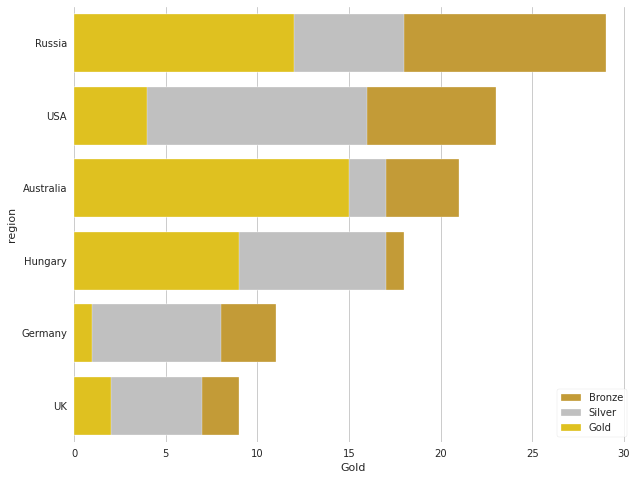

In [77]:
visual_medals(fm_medals_yr(1956))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

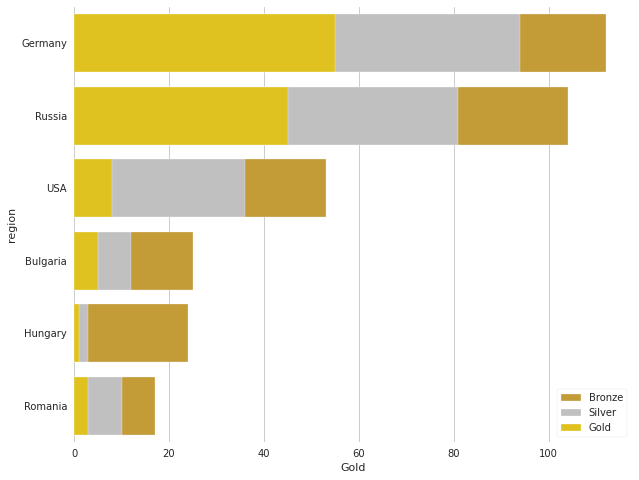

In [76]:
visual_medals(fm_medals_yr(1976))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

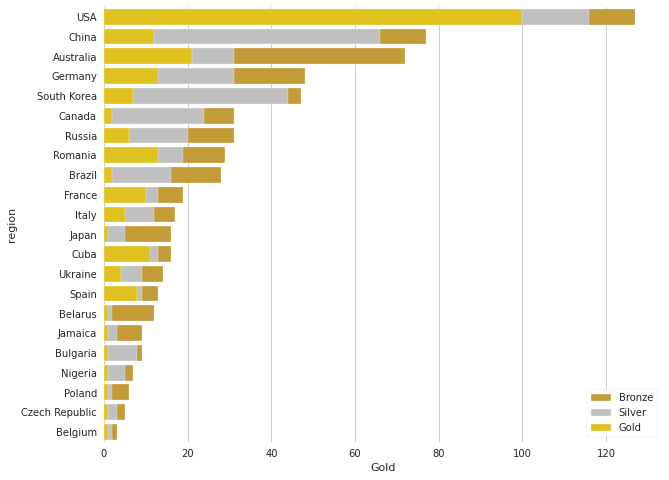

In [75]:
visual_medals(fm_medals_yr(1996))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

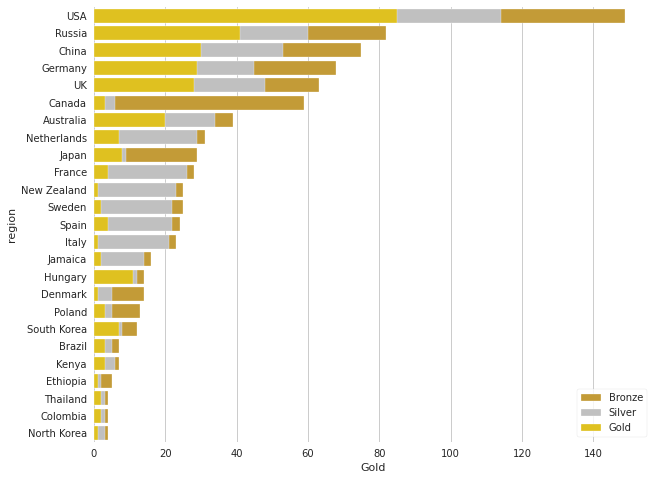

In [66]:
visual_medals(fm_medals_yr(2016))

Over time, female athletes from more and more countries participated in the Olympic Games and won medals.